<h3>导入包</h3>

In [1]:
import os
import logging
from datetime import datetime
from typing import Optional, Union
from chinese_calendar import is_workday, is_holiday, is_in_lieu, get_holiday_detail
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import zipfile
from zipfile import ZipFile
import numpy as np
import pandas as pd
from pandas import DataFrame, Series, Timestamp, Timedelta, DatetimeIndex
import matplotlib.pyplot as plt
from tqdm import tqdm
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.metrics import r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.base import RegressorMixin
from sklearn.metrics import r2_score
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, TimeDistributed, Dense, BatchNormalization
from tensorflow.keras.losses import MeanSquaredError, Huber
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, History
from tensorflow.keras.backend import clear_session
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.optimizers import Adam


tf.random.set_seed(42)
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
tf.compat.v1.reset_default_graph()
clear_session()


warnings.filterwarnings('ignore')
logging.basicConfig(format='%(asctime)s [%(levelname)s] %(message)s', level=logging.INFO)

<h3>读入数据</h3>

<h4>读入A榜数据</h4>

In [2]:
sub_sheet_name = ["二层插座", "二层照明", "一层插座", "一层照明", "空调"]
data_dict = {}
for name in sub_sheet_name:
    data_dict[name] = pd.read_csv('../data/Data_A/' + name + '_EC.csv')
    data_dict[name]["time"] = pd.to_datetime(data_dict[name]["time"])

<h4>读入B榜数据</h4>

In [3]:
sub_sheet_name = ["二层插座", "二层照明", "一层插座", "一层照明", "空调"]
for name in sub_sheet_name:
    data_b = pd.read_csv('../data/Data_B/' + name + '_EC_B.csv')
    data_b["time"] = pd.to_datetime(data_b["time"])
    data_dict[name] = pd.concat([data_dict[name], data_b], axis=0)
data_dict

{'二层插座':                    time     value
 0   2013-08-03 00:00:00  0.164062
 1   2013-08-03 00:15:00  0.121094
 2   2013-08-03 00:30:00  0.101562
 3   2013-08-03 00:45:00  0.087891
 4   2013-08-03 01:00:00  0.103516
 ..                  ...       ...
 667 2015-08-10 22:45:00  0.093750
 668 2015-08-10 23:00:00  0.089844
 669 2015-08-10 23:15:00  0.093750
 670 2015-08-10 23:30:00  0.097656
 671 2015-08-10 23:45:00  0.074219
 
 [64072 rows x 2 columns], '二层照明':                    time     value
 0   2013-08-03 00:00:00  0.500000
 1   2013-08-03 00:15:00  0.507812
 2   2013-08-03 00:30:00  0.476562
 3   2013-08-03 00:45:00  0.117188
 4   2013-08-03 01:00:00  0.000000
 ..                  ...       ...
 667 2015-08-10 22:45:00  0.062500
 668 2015-08-10 23:00:00  0.078125
 669 2015-08-10 23:15:00  0.062500
 670 2015-08-10 23:30:00  0.109375
 671 2015-08-10 23:45:00  0.273438
 
 [64320 rows x 2 columns], '一层插座':                    time     value
 0   2013-08-03 00:00:00  0.113281
 1   2013-

<h3>读入天气数据</h3>

In [4]:
wh = pd.read_csv("../data/Data_A/天气.csv")
wh["日期"] = pd.to_datetime(wh["日期"])
wh["time"] = wh["日期"] + pd.to_timedelta(wh["小时"], "h")
wh.drop(["Unnamed: 0", "日期", "小时"], axis=1, inplace=True)
wh = wh.set_index("time", drop=True)
wh

,温度(C°),湿度(%),降雨量(mm),大气压(hPa),风向,风向角度(°),风速(KM/H),云量(%)
time,,,,,,,,
2013-08-03 00:00:00,28,88,1.0,1006,东南风,159,9,71
2013-08-03 01:00:00,28,88,0.9,1006,东南风,155,8,75
2013-08-03 02:00:00,28,89,0.7,1006,东南风,150,8,54
2013-08-03 03:00:00,27,90,0.5,1006,东南风,151,8,25
2013-08-03 04:00:00,27,90,0.2,1006,东南风,151,8,35
...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,27,67,0.0,1006,东北风,43,11,1
2015-08-24 20:00:00,26,72,0.0,1007,东北风,45,9,0
2015-08-24 21:00:00,25,75,0.4,1007,东北风,35,7,2


<h3>合并数据</h3>

<h4>对齐数据</h4>

In [5]:
data = pd.merge(data_dict["二层插座"],data_dict["二层照明"],on='time', how="inner", suffixes=("_socket_2","_light_2"))
data = pd.merge(data,data_dict["一层插座"],on='time', how="inner", suffixes=("","_socket_1"))
data = pd.merge(data,data_dict["一层照明"],on='time', how="inner", suffixes=("","_light_1"))
data = pd.merge(data,data_dict["空调"],on='time', how="inner", suffixes=("","_air"))
data = data.rename(columns={"value":"value_socket_1"})
data

,time,value_socket_2,value_light_2,value_socket_1,value_light_1,value_air
0,2013-08-03 00:00:00,0.164062,0.500000,0.113281,0.542969,4.234375
1,2013-08-03 00:15:00,0.121094,0.507812,0.273438,0.542969,5.093750
2,2013-08-03 00:30:00,0.101562,0.476562,0.277344,0.515625,3.234375
3,2013-08-03 00:45:00,0.087891,0.117188,0.218750,0.437500,3.187500
4,2013-08-03 01:00:00,0.103516,0.000000,0.082031,0.406250,3.171875
...,...,...,...,...,...,...
63832,2015-08-10 22:45:00,0.093750,0.062500,0.125000,0.234375,1.750000
63833,2015-08-10 23:00:00,0.089844,0.078125,0.117188,0.218750,1.781250
63834,2015-08-10 23:15:00,0.093750,0.062500,0.132812,0.218750,1.718750
63835,2015-08-10 23:30:00,0.097656,0.109375,0.179688,0.203125,2.937500


<h4>将一二层数据相加</h4>

<AxesSubplot:>

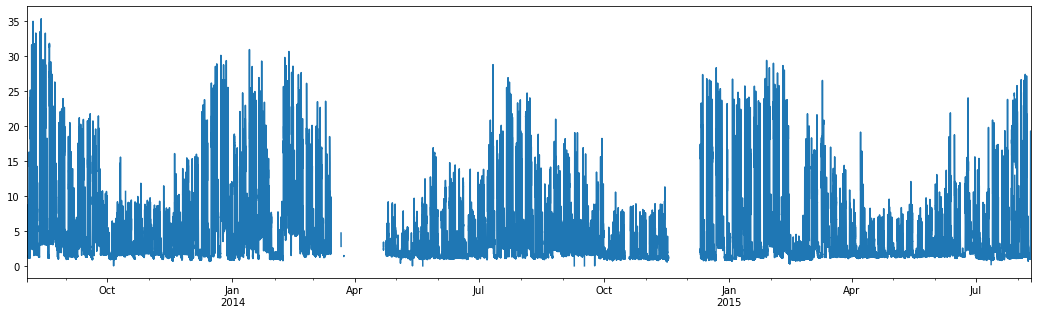

In [6]:
data["value_socket"] = data["value_socket_2"] + data["value_socket_1"]
data["value_light"] = data["value_light_2"] + data["value_light_1"]
data.drop(['value_socket_2','value_light_2','value_socket_1','value_light_1'], axis=1, inplace=True)
data["value_total"] = data.sum(axis=1)
data = data.set_index("time", drop=True)
data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq="15T"))
data["value_total"].plot(figsize=(18,5))

<h3>处理缺失值</h3>

<h4>查看大段的nan</h4>

In [7]:
data.loc['2014-03-14 13:00:00' : '2014-04-23 20:15:00']

,value_air,value_socket,value_light,value_total
2014-03-14 13:00:00,2.43750,1.539062,1.710938,5.687500
2014-03-14 13:15:00,2.37500,1.769531,1.777344,5.921875
2014-03-14 13:30:00,2.37500,1.347656,1.882812,5.605469
2014-03-14 13:45:00,NaN,NaN,NaN,NaN
2014-03-14 14:00:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2014-04-23 19:15:00,NaN,NaN,NaN,NaN
2014-04-23 19:30:00,NaN,NaN,NaN,NaN
2014-04-23 19:45:00,NaN,NaN,NaN,NaN
2014-04-23 20:00:00,NaN,NaN,NaN,NaN


In [8]:
data.loc['2014-11-17 08:00:00' : '2014-12-10 17:15:00']

,value_air,value_socket,value_light,value_total
2014-11-17 08:00:00,0.59375,0.390625,0.320312,1.304688
2014-11-17 08:15:00,0.59375,0.207031,0.281250,1.082031
2014-11-17 08:30:00,NaN,NaN,NaN,NaN
2014-11-17 08:45:00,NaN,NaN,NaN,NaN
2014-11-17 09:00:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2014-12-10 16:15:00,NaN,NaN,NaN,NaN
2014-12-10 16:30:00,NaN,NaN,NaN,NaN
2014-12-10 16:45:00,11.62500,1.718750,2.039062,15.382812
2014-12-10 17:00:00,12.15625,1.757812,2.039062,15.953125


<h4>查看所有缺失值的index，并将该小时的Timestamp记录下来</h4>

In [9]:
nan_index = data[data["value_total"].isnull()].index
nan_index_hours = []
for idx in nan_index:
    nan_index_hour = Timestamp(year=idx.year, month=idx.month, day=idx.day, hour=idx.hour)
    nan_index_hours.append(nan_index_hour)
nan_index_hours.extend(pd.date_range("2014-03-14 13:00:00", "2014-04-23 20:00:00", freq="1H").tolist())
nan_index_hours.extend(pd.date_range("2014-11-17 08:00:00", "2014-12-10 16:00:00", freq="1H").tolist())
nan_index_hours = np.unique(nan_index_hours)
DatetimeIndex(nan_index_hours)

DatetimeIndex(['2013-08-04 12:00:00', '2013-08-07 07:00:00',
               '2013-10-14 10:00:00', '2013-10-14 11:00:00',
               '2013-10-14 12:00:00', '2013-10-14 13:00:00',
               '2013-10-14 14:00:00', '2013-10-14 15:00:00',
               '2013-10-14 16:00:00', '2013-10-14 17:00:00',
               ...
               '2015-07-30 08:00:00', '2015-07-30 09:00:00',
               '2015-07-30 11:00:00', '2015-07-30 12:00:00',
               '2015-07-30 14:00:00', '2015-07-30 15:00:00',
               '2015-07-30 17:00:00', '2015-07-30 18:00:00',
               '2015-07-30 20:00:00', '2015-07-30 21:00:00'],
              dtype='datetime64[ns]', length=1860, freq=None)

<h4>对少数缺失值进行插值补全</h4>

In [10]:
data["value_air"] = data["value_air"].interpolate(method="time")
data["value_light"] = data["value_light"].interpolate(method="time")
data["value_socket"] = data["value_socket"].interpolate(method="time")
data["value_total"] = data["value_total"].interpolate(method="time")

<h3>按照每小时相加</h3>

In [11]:
data = data.resample("1H").sum()
data.loc["2014-03-14 13:00:00" : "2014-04-23 20:00:00", :] = np.nan
data.loc["2014-11-17 08:00:00" : "2014-12-10 16:00:00", :] = np.nan
data = data.dropna()
data

,value_air,value_socket,value_light,value_total
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484
...,...,...,...,...
2015-08-10 19:00:00,8.500000,1.277344,3.750000,13.527344
2015-08-10 20:00:00,3.531250,1.292969,2.382812,7.207031
2015-08-10 21:00:00,3.312500,1.203125,1.117188,5.632812
2015-08-10 22:00:00,5.000000,1.035156,1.234375,7.269531


<h3>合并天气数据</h3>

In [12]:
data = pd.merge(data, wh, how="right", left_index=True, right_index=True)
data

,value_air,value_socket,value_light,value_total,温度(C°),湿度(%),降雨量(mm),大气压(hPa),风向,风向角度(°),风速(KM/H),云量(%)
time,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,28,88,1.0,1006,东南风,159,9,71
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,28,88,0.9,1006,东南风,155,8,75
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,28,89,0.7,1006,东南风,150,8,54
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,27,90,0.5,1006,东南风,151,8,25
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,27,90,0.2,1006,东南风,151,8,35
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,27,67,0.0,1006,东北风,43,11,1
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,26,72,0.0,1007,东北风,45,9,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,25,75,0.4,1007,东北风,35,7,2


<h3>TODO 特征工程</h3>

<h4>修改列名</h4>

In [13]:
data = data.rename(columns={
    "温度(C°)":"temp",
    "湿度(%)":"humidity",
    "降雨量(mm)":"rainfall",
    "大气压(hPa)":"atmos",
    "风向":"wind_direction",
    "风向角度(°)":"wind_angle",
    "风速(KM/H)":"wind_speed",
    "云量(%)":"cloud"
})

<h4>自定义特征工程</h4>

In [14]:
data['workday'] = list(map(lambda x: int(is_workday(x)), data.index.to_list()))
data['hour'] = list(map(lambda x: x.hour, data.index.to_list()))
data['week'] = list(map(lambda x: x.weekday(), data.index.to_list()))
data['day'] = list(map(lambda x: x.day, data.index.to_list()))
data['month'] = list(map(lambda x: x.month, data.index.to_list()))
data['year'] = list(map(lambda x: x.year, data.index.to_list()))
data["temp"] = data["temp"].rolling("12H").mean()
data["is_summer"] = data["month"].apply(lambda x: x in (6, 7, 8)).astype(int)
data["is_winter"] = data["month"].apply(lambda x: x in (12, 1, 2)).astype(int)
data["value_air"] = data["value_air"] / data["value_total"]
data["value_socket"] = data["value_socket"] / data["value_total"]
data["value_light"] = data["value_light"] / data["value_total"]
# data = pd.concat([data.loc[: "2015-08-03 23:00:00"].dropna(), data.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00"]], axis=0)
data

,value_air,value_socket,value_light,value_total,temp,humidity,rainfall,atmos,wind_direction,wind_angle,wind_speed,cloud,workday,hour,week,day,month,year,is_summer,is_winter
time,,,,,,,,,,,,,,,,,,,,
2013-08-03 00:00:00,0.759108,0.065424,0.175468,20.748047,28.000000,88,1.0,1006,东南风,159,9,71,0,0,5,3,8,2013,1,0
2013-08-03 01:00:00,0.837381,0.053062,0.109556,14.796875,28.000000,88,0.9,1006,东南风,155,8,75,0,1,5,3,8,2013,1,0
2013-08-03 02:00:00,0.820003,0.057757,0.122240,13.357422,28.000000,89,0.7,1006,东南风,150,8,54,0,2,5,3,8,2013,1,0
2013-08-03 03:00:00,0.822779,0.060207,0.117014,13.787109,27.750000,90,0.5,1006,东南风,151,8,25,0,3,5,3,8,2013,1,0
2013-08-03 04:00:00,0.809886,0.074273,0.115841,15.646484,27.600000,90,0.2,1006,东南风,151,8,35,0,4,5,3,8,2013,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,28.500000,67,0.0,1006,东北风,43,11,1,1,19,0,24,8,2015,1,0
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,28.583333,72,0.0,1007,东北风,45,9,0,1,20,0,24,8,2015,1,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,28.500000,75,0.4,1007,东北风,35,7,2,1,21,0,24,8,2015,1,0


<h3>对类别特征onehot</h3>

<h4>对风向进行onehot</h4>

In [15]:
onehot_wind = OneHotEncoder(sparse=False)
onehot_wind.fit(data[["wind_direction"]])
data = pd.concat([data, DataFrame(onehot_wind.transform(data[["wind_direction"]]), columns=onehot_wind.categories_[0], index=data.index).astype(int)], axis=1)
data = data.drop(columns=["wind_direction"])
data

,value_air,value_socket,value_light,value_total,temp,humidity,rainfall,atmos,wind_angle,wind_speed,...,is_summer,is_winter,东北风,东南风,东风,北风,南风,西北风,西南风,西风
time,,,,,,,,,,,,,,,,,,,,,
2013-08-03 00:00:00,0.759108,0.065424,0.175468,20.748047,28.000000,88,1.0,1006,159,9,...,1,0,0,1,0,0,0,0,0,0
2013-08-03 01:00:00,0.837381,0.053062,0.109556,14.796875,28.000000,88,0.9,1006,155,8,...,1,0,0,1,0,0,0,0,0,0
2013-08-03 02:00:00,0.820003,0.057757,0.122240,13.357422,28.000000,89,0.7,1006,150,8,...,1,0,0,1,0,0,0,0,0,0
2013-08-03 03:00:00,0.822779,0.060207,0.117014,13.787109,27.750000,90,0.5,1006,151,8,...,1,0,0,1,0,0,0,0,0,0
2013-08-03 04:00:00,0.809886,0.074273,0.115841,15.646484,27.600000,90,0.2,1006,151,8,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,28.500000,67,0.0,1006,43,11,...,1,0,1,0,0,0,0,0,0,0
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,28.583333,72,0.0,1007,45,9,...,1,0,1,0,0,0,0,0,0,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,28.500000,75,0.4,1007,35,7,...,1,0,1,0,0,0,0,0,0,0


<h4>对星期几进行onehot</h4>

In [16]:
data["week"] = data["week"].apply(lambda x: "星期" + str(x + 1))
onehot_week = OneHotEncoder(sparse=False)
onehot_week.fit(data[["week"]])
data = pd.concat([data, DataFrame(onehot_week.transform(data[["week"]]), columns=onehot_week.categories_[0], index=data.index).astype(int)], axis=1)
data = data.drop(columns=["week"])
data

,value_air,value_socket,value_light,value_total,temp,humidity,rainfall,atmos,wind_angle,wind_speed,...,西北风,西南风,西风,星期1,星期2,星期3,星期4,星期5,星期6,星期7
time,,,,,,,,,,,,,,,,,,,,,
2013-08-03 00:00:00,0.759108,0.065424,0.175468,20.748047,28.000000,88,1.0,1006,159,9,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 01:00:00,0.837381,0.053062,0.109556,14.796875,28.000000,88,0.9,1006,155,8,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 02:00:00,0.820003,0.057757,0.122240,13.357422,28.000000,89,0.7,1006,150,8,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 03:00:00,0.822779,0.060207,0.117014,13.787109,27.750000,90,0.5,1006,151,8,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 04:00:00,0.809886,0.074273,0.115841,15.646484,27.600000,90,0.2,1006,151,8,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,28.500000,67,0.0,1006,43,11,...,0,0,0,1,0,0,0,0,0,0
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,28.583333,72,0.0,1007,45,9,...,0,0,0,1,0,0,0,0,0,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,28.500000,75,0.4,1007,35,7,...,0,0,0,1,0,0,0,0,0,0


<h3>构建模型</h3>

In [17]:
def r2_metric(y_pred, y_true):
    result1 = r2_score(y_true[0:24], y_pred[0:24])
    result2 = r2_score(y_true[24:48], y_pred[24:48])
    result3 = r2_score(y_true[48:72], y_pred[48:72])
    result4 = r2_score(y_true[72:96], y_pred[72:96])
    result5 = r2_score(y_true[96:120], y_pred[96:120])
    result6 = r2_score(y_true[120:144], y_pred[120:144])
    result7 = r2_score(y_true[144:168], y_pred[144:168])
    return "r2 score", 0.25 * result1 + 0.15 * (result2 + result3 + result4) + 0.1 * (result5 + result6 + result7), True

In [18]:
def cross_validation(estimator: RegressorMixin, n_splits: int, x_train_val: DataFrame, y_train_val: Series, x_test: DataFrame) -> np.ndarray:
    """
    交叉验证\n
    """
    models = []
    scores = []
    oof_preds = np.zeros((x_train_val.shape[0],))
    test_preds = np.zeros((x_test.shape[0],))
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for fold, (train_index, val_index) in enumerate(kfold.split(x_train_val, y_train_val)):
        x_train, x_val, y_train, y_val = x_train_val.iloc[train_index], x_train_val.iloc[val_index], y_train_val[train_index], y_train_val[val_index]

        estimator = estimator.fit(x_train, y_train, eval_set=(x_val, y_val), eval_metric=r2_metric, early_stopping_rounds=20)
        models.append(estimator)

        oof_preds[val_index] = estimator.predict(x_val, num_iteration=estimator.best_iteration_)
        test_preds += estimator.predict(x_test, num_iteration=estimator.best_iteration_) / kfold.n_splits
        score = r2_score(y_val, estimator.predict(x_val, num_iteration=estimator.best_iteration_))
        
        logging.info(f'############ fold: {fold}, r2: {score} ###########')
        scores.append(score)
    logging.info(f'############ cross validation r2 score: {np.mean(scores)} ###########')
    return test_preds

In [19]:
def shift_column(ser: Series, num: int) -> DataFrame:
    """
    取历史值\n
    """
    result = DataFrame()
    for i in range(1, num + 1):
        result["%s-%d" % (ser.name, i)] = ser.shift(i)
    return result

In [20]:
def clip_maxmin(ser: Series, _clip_min_: bool, _clip_max_: bool) -> Series:
    """
    把最小值最大值变为次小值次大值\n
    """
    result = ser.copy()
    if _clip_min_:
        idx = result.argmin()
        result[result == result.min()] = np.nan
        result.iloc[idx] = result.min()
    if _clip_max_:
        idx = result.argmax()
        result[result == result.max()] == np.nan
        result.iloc[idx] = result.max()
    return result

In [21]:
def clip_value(ser: Union[Series, np.ndarray], _min_val_: Optional[float] = None, _max_val_: Optional[float] = None) -> Series:
    """
    把小于最小值的替换成最小值\n
    """
    result = ser.copy()
    if _min_val_:
        result[result < _min_val_] = _min_val_
    if _max_val_:
        result[result > _max_val_] = _max_val_
    return result

In [22]:
@tf.function
def split_xy(x):
    return x[:, :, 1:], x[:, :, 0]

<h4>针对socket构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

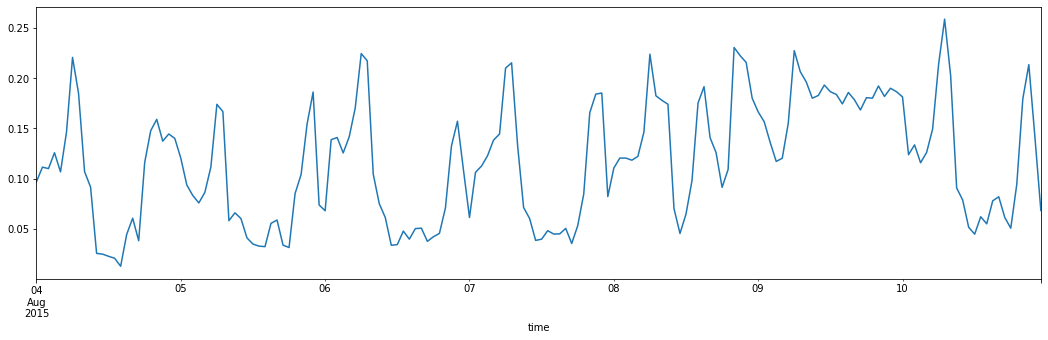

In [23]:
data.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00", "value_socket"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [24]:
data_socket = data.drop(columns=["value_light", "value_air", "value_total"])
x_train_socket = data_socket.drop(columns=["value_socket"]).loc[: "2015-08-10 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_socket = data_socket["value_socket"].loc[: "2015-08-10 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
x_test_socket = data_socket.drop(columns=["value_socket"]).loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00"]

sample_weight = np.arange(0, x_train_socket.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [25]:
model_socket1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_socket, y_train_socket, sample_weight=sample_weight)
socket_pred1 = model_socket1.predict(x_test_socket)

<h5>取最后7*24个点作为模型2预测值</h5>

In [26]:
socket_pred2 = data_socket.loc[: "2015-08-10 23:00:00", "value_socket"].values[-7*24:]

<h5>构建catboost</h5>

In [27]:
model_socket3 = CatBoostRegressor(n_estimators=1000, random_state=1024).fit(x_train_socket, y_train_socket, sample_weight=sample_weight)
socket_pred3 = model_socket3.predict(x_test_socket)

Learning rate set to 0.063357
0:	learn: 0.0789792	total: 55.5ms	remaining: 55.5s
1:	learn: 0.0778389	total: 57.7ms	remaining: 28.8s
2:	learn: 0.0767961	total: 59.8ms	remaining: 19.9s
3:	learn: 0.0758457	total: 61.9ms	remaining: 15.4s
4:	learn: 0.0750186	total: 63.9ms	remaining: 12.7s
5:	learn: 0.0742855	total: 66ms	remaining: 10.9s
6:	learn: 0.0735358	total: 68ms	remaining: 9.65s
7:	learn: 0.0727809	total: 70ms	remaining: 8.69s
8:	learn: 0.0720734	total: 72.1ms	remaining: 7.94s
9:	learn: 0.0713702	total: 74.3ms	remaining: 7.36s
10:	learn: 0.0708258	total: 76.4ms	remaining: 6.87s
11:	learn: 0.0702898	total: 78.5ms	remaining: 6.47s
12:	learn: 0.0697339	total: 80.8ms	remaining: 6.14s
13:	learn: 0.0692661	total: 82.8ms	remaining: 5.83s
14:	learn: 0.0688508	total: 84.7ms	remaining: 5.56s
15:	learn: 0.0684282	total: 86.8ms	remaining: 5.34s
16:	learn: 0.0680313	total: 88.7ms	remaining: 5.13s
17:	learn: 0.0676760	total: 90.7ms	remaining: 4.95s
18:	learn: 0.0673361	total: 92.7ms	remaining: 4.79

238:	learn: 0.0468579	total: 532ms	remaining: 1.69s
239:	learn: 0.0468165	total: 534ms	remaining: 1.69s
240:	learn: 0.0467859	total: 536ms	remaining: 1.69s
241:	learn: 0.0467370	total: 538ms	remaining: 1.68s
242:	learn: 0.0467014	total: 539ms	remaining: 1.68s
243:	learn: 0.0466695	total: 541ms	remaining: 1.68s
244:	learn: 0.0466548	total: 543ms	remaining: 1.67s
245:	learn: 0.0466235	total: 545ms	remaining: 1.67s
246:	learn: 0.0465963	total: 547ms	remaining: 1.67s
247:	learn: 0.0465279	total: 549ms	remaining: 1.67s
248:	learn: 0.0464958	total: 552ms	remaining: 1.66s
249:	learn: 0.0464578	total: 553ms	remaining: 1.66s
250:	learn: 0.0464129	total: 555ms	remaining: 1.66s
251:	learn: 0.0463800	total: 557ms	remaining: 1.65s
252:	learn: 0.0463344	total: 559ms	remaining: 1.65s
253:	learn: 0.0463100	total: 561ms	remaining: 1.65s
254:	learn: 0.0462809	total: 563ms	remaining: 1.64s
255:	learn: 0.0462372	total: 565ms	remaining: 1.64s
256:	learn: 0.0461968	total: 567ms	remaining: 1.64s
257:	learn: 

421:	learn: 0.0415206	total: 892ms	remaining: 1.22s
422:	learn: 0.0415024	total: 894ms	remaining: 1.22s
423:	learn: 0.0414751	total: 896ms	remaining: 1.22s
424:	learn: 0.0414556	total: 898ms	remaining: 1.21s
425:	learn: 0.0414205	total: 900ms	remaining: 1.21s
426:	learn: 0.0413970	total: 902ms	remaining: 1.21s
427:	learn: 0.0413852	total: 904ms	remaining: 1.21s
428:	learn: 0.0413449	total: 905ms	remaining: 1.21s
429:	learn: 0.0413123	total: 907ms	remaining: 1.2s
430:	learn: 0.0412787	total: 909ms	remaining: 1.2s
431:	learn: 0.0412379	total: 911ms	remaining: 1.2s
432:	learn: 0.0412212	total: 913ms	remaining: 1.2s
433:	learn: 0.0411943	total: 915ms	remaining: 1.19s
434:	learn: 0.0411662	total: 917ms	remaining: 1.19s
435:	learn: 0.0411502	total: 919ms	remaining: 1.19s
436:	learn: 0.0411286	total: 921ms	remaining: 1.19s
437:	learn: 0.0411000	total: 923ms	remaining: 1.18s
438:	learn: 0.0410841	total: 925ms	remaining: 1.18s
439:	learn: 0.0410595	total: 927ms	remaining: 1.18s
440:	learn: 0.04

609:	learn: 0.0380574	total: 1.25s	remaining: 799ms
610:	learn: 0.0380448	total: 1.25s	remaining: 797ms
611:	learn: 0.0380272	total: 1.25s	remaining: 795ms
612:	learn: 0.0380156	total: 1.25s	remaining: 793ms
613:	learn: 0.0379979	total: 1.26s	remaining: 791ms
614:	learn: 0.0379837	total: 1.26s	remaining: 788ms
615:	learn: 0.0379680	total: 1.26s	remaining: 786ms
616:	learn: 0.0379491	total: 1.26s	remaining: 784ms
617:	learn: 0.0379282	total: 1.26s	remaining: 782ms
618:	learn: 0.0379143	total: 1.27s	remaining: 780ms
619:	learn: 0.0378821	total: 1.27s	remaining: 778ms
620:	learn: 0.0378683	total: 1.27s	remaining: 776ms
621:	learn: 0.0378523	total: 1.27s	remaining: 773ms
622:	learn: 0.0378371	total: 1.27s	remaining: 771ms
623:	learn: 0.0378275	total: 1.28s	remaining: 769ms
624:	learn: 0.0378175	total: 1.28s	remaining: 767ms
625:	learn: 0.0378108	total: 1.28s	remaining: 765ms
626:	learn: 0.0378036	total: 1.28s	remaining: 763ms
627:	learn: 0.0377827	total: 1.28s	remaining: 761ms
628:	learn: 

793:	learn: 0.0354860	total: 1.61s	remaining: 417ms
794:	learn: 0.0354671	total: 1.61s	remaining: 415ms
795:	learn: 0.0354533	total: 1.61s	remaining: 413ms
796:	learn: 0.0354455	total: 1.61s	remaining: 411ms
797:	learn: 0.0354405	total: 1.62s	remaining: 409ms
798:	learn: 0.0354272	total: 1.62s	remaining: 407ms
799:	learn: 0.0354076	total: 1.62s	remaining: 405ms
800:	learn: 0.0353974	total: 1.62s	remaining: 403ms
801:	learn: 0.0353848	total: 1.62s	remaining: 401ms
802:	learn: 0.0353629	total: 1.63s	remaining: 399ms
803:	learn: 0.0353524	total: 1.63s	remaining: 397ms
804:	learn: 0.0353511	total: 1.63s	remaining: 395ms
805:	learn: 0.0353354	total: 1.63s	remaining: 393ms
806:	learn: 0.0353294	total: 1.63s	remaining: 391ms
807:	learn: 0.0353179	total: 1.64s	remaining: 389ms
808:	learn: 0.0352948	total: 1.64s	remaining: 387ms
809:	learn: 0.0352854	total: 1.64s	remaining: 385ms
810:	learn: 0.0352760	total: 1.64s	remaining: 383ms
811:	learn: 0.0352675	total: 1.64s	remaining: 381ms
812:	learn: 

975:	learn: 0.0335628	total: 1.97s	remaining: 48.4ms
976:	learn: 0.0335573	total: 1.97s	remaining: 46.4ms
977:	learn: 0.0335414	total: 1.97s	remaining: 44.3ms
978:	learn: 0.0335272	total: 1.97s	remaining: 42.3ms
979:	learn: 0.0335175	total: 1.98s	remaining: 40.3ms
980:	learn: 0.0335021	total: 1.98s	remaining: 38.3ms
981:	learn: 0.0334957	total: 1.98s	remaining: 36.3ms
982:	learn: 0.0334892	total: 1.98s	remaining: 34.3ms
983:	learn: 0.0334744	total: 1.98s	remaining: 32.2ms
984:	learn: 0.0334602	total: 1.98s	remaining: 30.2ms
985:	learn: 0.0334508	total: 1.99s	remaining: 28.2ms
986:	learn: 0.0334440	total: 1.99s	remaining: 26.2ms
987:	learn: 0.0334376	total: 1.99s	remaining: 24.2ms
988:	learn: 0.0334266	total: 1.99s	remaining: 22.2ms
989:	learn: 0.0334216	total: 1.99s	remaining: 20.1ms
990:	learn: 0.0334130	total: 2s	remaining: 18.1ms
991:	learn: 0.0334010	total: 2s	remaining: 16.1ms
992:	learn: 0.0333926	total: 2s	remaining: 14.1ms
993:	learn: 0.0333865	total: 2s	remaining: 12.1ms
994:	

<h5>构建xgboost</h5>

In [28]:
model_socket4 = XGBRegressor(n_estimators=1000, objective='reg:gamma', n_jobs=-1, random_state=1024).fit(x_train_socket, y_train_socket)
socket_pred4 = model_socket4.predict(x_test_socket)

<h5>构建深度模型</h5>

In [29]:
ds_socket1 = timeseries_dataset_from_array(
    data=data_socket.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_socket2 = timeseries_dataset_from_array(
    data=data_socket.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_socket3 = timeseries_dataset_from_array(
    data=data_socket.loc["2014-12-10 17:00:00" : "2015-08-10 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_socket = ds_socket1.concatenate(ds_socket2).concatenate(ds_socket3).map(split_xy)
ds_socket

<MapDataset shapes: ((None, None, 29), (None, None)), types: (tf.float64, tf.float64)>

Epoch 1/100
124/124 [==============================] - 8s 40ms/step - loss: 0.0072 - mae: 0.0624
Epoch 2/100
124/124 [==============================] - 5s 39ms/step - loss: 0.0037 - mae: 0.0464
Epoch 3/100
124/124 [==============================] - 5s 39ms/step - loss: 0.0033 - mae: 0.0430
Epoch 4/100
124/124 [==============================] - 5s 39ms/step - loss: 0.0029 - mae: 0.0405
Epoch 5/100
124/124 [==============================] - 5s 38ms/step - loss: 0.0026 - mae: 0.0377
Epoch 6/100
124/124 [==============================] - 5s 39ms/step - loss: 0.0023 - mae: 0.0357
Epoch 7/100
124/124 [==============================] - 5s 39ms/step - loss: 0.0021 - mae: 0.0339
Epoch 8/100
124/124 [==============================] - 5s 39ms/step - loss: 0.0020 - mae: 0.0326
Epoch 9/100
124/124 [==============================] - 5s 39ms/step - loss: 0.0018 - mae: 0.0312
Epoch 10/100
124/124 [==============================] - 5s 38ms/step - loss: 0.0017 - mae: 0.0299
Epoch 11/100
124/124 [=======

124/124 [==============================] - 5s 41ms/step - loss: 3.0477e-04 - mae: 0.0115
Epoch 83/100
124/124 [==============================] - 5s 40ms/step - loss: 3.0041e-04 - mae: 0.0114
Epoch 84/100
124/124 [==============================] - 5s 40ms/step - loss: 3.0855e-04 - mae: 0.0116
Epoch 85/100
124/124 [==============================] - 5s 40ms/step - loss: 2.9964e-04 - mae: 0.0114
Epoch 86/100
124/124 [==============================] - 5s 40ms/step - loss: 2.8899e-04 - mae: 0.0112
Epoch 87/100
124/124 [==============================] - 5s 40ms/step - loss: 2.7842e-04 - mae: 0.0109
Epoch 88/100
124/124 [==============================] - 5s 41ms/step - loss: 2.7899e-04 - mae: 0.0109
Epoch 89/100
124/124 [==============================] - 5s 40ms/step - loss: 2.8068e-04 - mae: 0.0109
Epoch 90/100
124/124 [==============================] - 5s 40ms/step - loss: 2.8473e-04 - mae: 0.0111
Epoch 91/100
124/124 [==============================] - 5s 40ms/step - loss: 2.7781e-04 - mae: 

2023-04-12 08:52:49,804 [INFO] saving LSTM model to ../models/LSTM_socket.h5


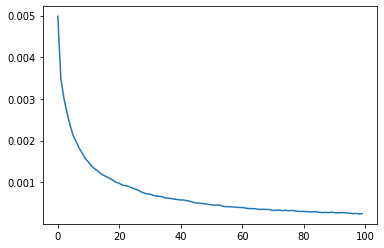

In [30]:
model_socket5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_socket.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_socket5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_socket5.load_weights("../models/LSTM_socket.h5")
    logging.info("loading LSTM model from ../models/LSTM_socket.h5")
except OSError as e:
    history: History = model_socket5.fit(
        ds_socket,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_socket5.save_weights("../models/LSTM_socket.h5")
    logging.info("saving LSTM model to ../models/LSTM_socket.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

In [31]:
socket_pred5 = model_socket5.predict(np.expand_dims(x_test_socket.values, 0))[0, :, 0]

<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

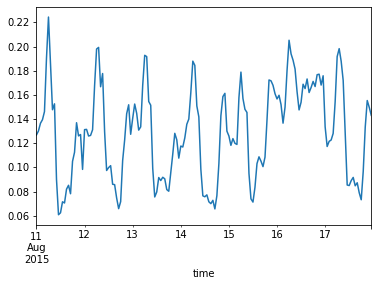

In [32]:
socket_pred = (socket_pred1 + socket_pred2 + socket_pred3 + socket_pred4 + socket_pred5) / 5
data_socket.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_socket"] = socket_pred
data_socket.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_socket"].plot()

<h4>针对light构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

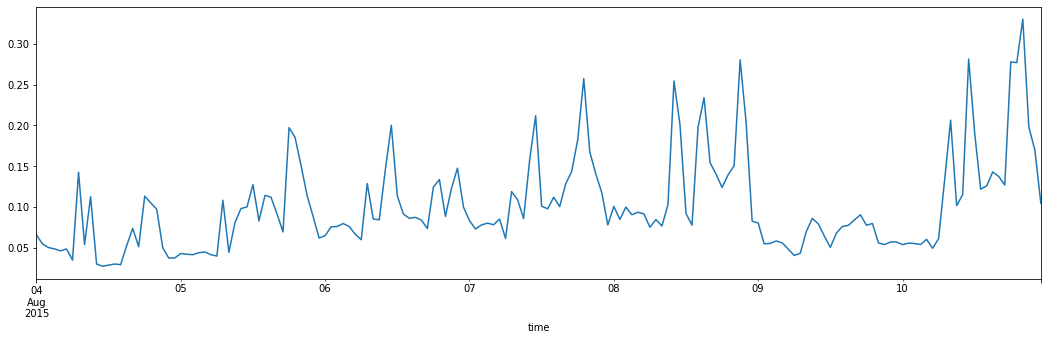

In [33]:
data.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00", "value_light"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [34]:
data_light = data.drop(columns=["value_socket", "value_air", "value_total", 'temp', 'humidity', 'atmos', 'wind_angle', 'wind_speed'])
x_train_light = data_light.drop(columns=["value_light"]).loc[: "2015-08-10 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_light = data_light["value_light"].loc[: "2015-08-10 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
x_test_light = data_light.drop(columns=["value_light"]).loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00"]

sample_weight = np.arange(0, x_train_light.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [35]:
model_light1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_light, y_train_light, sample_weight=sample_weight)
light_pred1 = model_light1.predict(x_test_light)

<h5>取最后7*24个点作为模型2预测值</h5>

In [36]:
light_pred2 = data_light.loc[: "2015-08-10 23:00:00", "value_light"].values[-7*24:]

<h5>构建catboost</h5>

In [37]:
model_light3 = CatBoostRegressor(n_estimators=1000, random_state=1024).fit(x_train_light, y_train_light, sample_weight=sample_weight)
light_pred3 = model_light3.predict(x_test_light)

Learning rate set to 0.063357
0:	learn: 0.1168213	total: 2.7ms	remaining: 2.7s
1:	learn: 0.1138138	total: 5.23ms	remaining: 2.61s
2:	learn: 0.1110599	total: 7.66ms	remaining: 2.54s
3:	learn: 0.1086073	total: 10ms	remaining: 2.5s
4:	learn: 0.1063662	total: 12.5ms	remaining: 2.48s
5:	learn: 0.1043590	total: 14.9ms	remaining: 2.47s
6:	learn: 0.1026336	total: 17.3ms	remaining: 2.45s
7:	learn: 0.1009504	total: 19.7ms	remaining: 2.45s
8:	learn: 0.0994319	total: 22.2ms	remaining: 2.44s
9:	learn: 0.0980832	total: 24.5ms	remaining: 2.43s
10:	learn: 0.0967536	total: 26.8ms	remaining: 2.41s
11:	learn: 0.0955304	total: 29.2ms	remaining: 2.41s
12:	learn: 0.0944040	total: 31.6ms	remaining: 2.4s
13:	learn: 0.0934488	total: 34ms	remaining: 2.39s
14:	learn: 0.0924942	total: 36.4ms	remaining: 2.39s
15:	learn: 0.0916266	total: 38.7ms	remaining: 2.38s
16:	learn: 0.0907520	total: 41.1ms	remaining: 2.38s
17:	learn: 0.0900064	total: 43.4ms	remaining: 2.37s
18:	learn: 0.0892658	total: 45.8ms	remaining: 2.36s


162:	learn: 0.0665130	total: 350ms	remaining: 1.8s
163:	learn: 0.0664494	total: 353ms	remaining: 1.8s
164:	learn: 0.0663961	total: 355ms	remaining: 1.79s
165:	learn: 0.0663124	total: 357ms	remaining: 1.79s
166:	learn: 0.0662656	total: 359ms	remaining: 1.79s
167:	learn: 0.0662171	total: 361ms	remaining: 1.79s
168:	learn: 0.0661071	total: 364ms	remaining: 1.79s
169:	learn: 0.0660372	total: 366ms	remaining: 1.79s
170:	learn: 0.0659803	total: 368ms	remaining: 1.79s
171:	learn: 0.0659215	total: 371ms	remaining: 1.78s
172:	learn: 0.0658684	total: 373ms	remaining: 1.78s
173:	learn: 0.0658297	total: 376ms	remaining: 1.78s
174:	learn: 0.0657713	total: 378ms	remaining: 1.78s
175:	learn: 0.0657324	total: 381ms	remaining: 1.78s
176:	learn: 0.0656676	total: 383ms	remaining: 1.78s
177:	learn: 0.0656080	total: 386ms	remaining: 1.78s
178:	learn: 0.0655545	total: 388ms	remaining: 1.78s
179:	learn: 0.0654953	total: 391ms	remaining: 1.78s
180:	learn: 0.0654389	total: 393ms	remaining: 1.78s
181:	learn: 0.

332:	learn: 0.0587937	total: 708ms	remaining: 1.42s
333:	learn: 0.0587493	total: 711ms	remaining: 1.42s
334:	learn: 0.0587247	total: 713ms	remaining: 1.42s
335:	learn: 0.0586853	total: 715ms	remaining: 1.41s
336:	learn: 0.0586513	total: 717ms	remaining: 1.41s
337:	learn: 0.0586137	total: 719ms	remaining: 1.41s
338:	learn: 0.0585830	total: 721ms	remaining: 1.41s
339:	learn: 0.0585575	total: 724ms	remaining: 1.4s
340:	learn: 0.0585209	total: 726ms	remaining: 1.4s
341:	learn: 0.0584879	total: 728ms	remaining: 1.4s
342:	learn: 0.0584387	total: 730ms	remaining: 1.4s
343:	learn: 0.0584115	total: 732ms	remaining: 1.4s
344:	learn: 0.0583823	total: 734ms	remaining: 1.39s
345:	learn: 0.0583585	total: 736ms	remaining: 1.39s
346:	learn: 0.0583339	total: 738ms	remaining: 1.39s
347:	learn: 0.0583005	total: 740ms	remaining: 1.39s
348:	learn: 0.0582625	total: 742ms	remaining: 1.38s
349:	learn: 0.0582319	total: 744ms	remaining: 1.38s
350:	learn: 0.0581981	total: 746ms	remaining: 1.38s
351:	learn: 0.058

504:	learn: 0.0542349	total: 1.07s	remaining: 1.05s
505:	learn: 0.0542050	total: 1.07s	remaining: 1.04s
506:	learn: 0.0541864	total: 1.07s	remaining: 1.04s
507:	learn: 0.0541527	total: 1.07s	remaining: 1.04s
508:	learn: 0.0541313	total: 1.07s	remaining: 1.04s
509:	learn: 0.0541176	total: 1.08s	remaining: 1.04s
510:	learn: 0.0541066	total: 1.08s	remaining: 1.04s
511:	learn: 0.0540888	total: 1.08s	remaining: 1.03s
512:	learn: 0.0540696	total: 1.09s	remaining: 1.03s
513:	learn: 0.0540414	total: 1.09s	remaining: 1.03s
514:	learn: 0.0540230	total: 1.09s	remaining: 1.03s
515:	learn: 0.0540059	total: 1.09s	remaining: 1.03s
516:	learn: 0.0539823	total: 1.1s	remaining: 1.02s
517:	learn: 0.0539653	total: 1.1s	remaining: 1.02s
518:	learn: 0.0539474	total: 1.1s	remaining: 1.02s
519:	learn: 0.0539272	total: 1.1s	remaining: 1.02s
520:	learn: 0.0539140	total: 1.1s	remaining: 1.02s
521:	learn: 0.0538887	total: 1.11s	remaining: 1.01s
522:	learn: 0.0538670	total: 1.11s	remaining: 1.01s
523:	learn: 0.053

674:	learn: 0.0511271	total: 1.43s	remaining: 686ms
675:	learn: 0.0511095	total: 1.43s	remaining: 684ms
676:	learn: 0.0510941	total: 1.43s	remaining: 682ms
677:	learn: 0.0510718	total: 1.43s	remaining: 680ms
678:	learn: 0.0510464	total: 1.43s	remaining: 678ms
679:	learn: 0.0510270	total: 1.44s	remaining: 676ms
680:	learn: 0.0510165	total: 1.44s	remaining: 674ms
681:	learn: 0.0509992	total: 1.44s	remaining: 672ms
682:	learn: 0.0509861	total: 1.44s	remaining: 670ms
683:	learn: 0.0509772	total: 1.44s	remaining: 667ms
684:	learn: 0.0509672	total: 1.45s	remaining: 665ms
685:	learn: 0.0509552	total: 1.45s	remaining: 663ms
686:	learn: 0.0509429	total: 1.45s	remaining: 661ms
687:	learn: 0.0509315	total: 1.45s	remaining: 659ms
688:	learn: 0.0509240	total: 1.46s	remaining: 657ms
689:	learn: 0.0509064	total: 1.46s	remaining: 655ms
690:	learn: 0.0508934	total: 1.46s	remaining: 653ms
691:	learn: 0.0508683	total: 1.46s	remaining: 651ms
692:	learn: 0.0508523	total: 1.46s	remaining: 648ms
693:	learn: 

843:	learn: 0.0487177	total: 1.78s	remaining: 330ms
844:	learn: 0.0487086	total: 1.79s	remaining: 328ms
845:	learn: 0.0486956	total: 1.79s	remaining: 326ms
846:	learn: 0.0486843	total: 1.79s	remaining: 324ms
847:	learn: 0.0486711	total: 1.79s	remaining: 321ms
848:	learn: 0.0486597	total: 1.79s	remaining: 319ms
849:	learn: 0.0486493	total: 1.8s	remaining: 317ms
850:	learn: 0.0486339	total: 1.8s	remaining: 315ms
851:	learn: 0.0486152	total: 1.8s	remaining: 313ms
852:	learn: 0.0486045	total: 1.8s	remaining: 311ms
853:	learn: 0.0485817	total: 1.81s	remaining: 309ms
854:	learn: 0.0485720	total: 1.81s	remaining: 307ms
855:	learn: 0.0485614	total: 1.81s	remaining: 305ms
856:	learn: 0.0485454	total: 1.81s	remaining: 302ms
857:	learn: 0.0485244	total: 1.81s	remaining: 300ms
858:	learn: 0.0485198	total: 1.82s	remaining: 298ms
859:	learn: 0.0485033	total: 1.82s	remaining: 296ms
860:	learn: 0.0484963	total: 1.82s	remaining: 294ms
861:	learn: 0.0484856	total: 1.82s	remaining: 292ms
862:	learn: 0.04

<h5>构建xgboost</h5>

In [38]:
model_light4 = XGBRegressor(n_estimators=1000, objective='reg:gamma', n_jobs=-1, random_state=1024).fit(x_train_light, y_train_light)
light_pred4 = model_light4.predict(x_test_light)

<h5>构建深度模型</h5>

In [39]:
ds_light1 = timeseries_dataset_from_array(
    data=data_light.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_light2 = timeseries_dataset_from_array(
    data=data_light.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_light3 = timeseries_dataset_from_array(
    data=data_light.loc["2014-12-10 17:00:00" : "2015-08-10 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_light = ds_light1.concatenate(ds_light2).concatenate(ds_light3).map(split_xy)
ds_light

<MapDataset shapes: ((None, None, 24), (None, None)), types: (tf.float64, tf.float64)>

Epoch 1/100
124/124 [==============================] - 8s 43ms/step - loss: 0.0204 - mae: 0.1043
Epoch 2/100
124/124 [==============================] - 5s 39ms/step - loss: 0.0079 - mae: 0.0667
Epoch 3/100
124/124 [==============================] - 5s 39ms/step - loss: 0.0068 - mae: 0.0615
Epoch 4/100
124/124 [==============================] - 5s 39ms/step - loss: 0.0058 - mae: 0.0566
Epoch 5/100
124/124 [==============================] - 5s 39ms/step - loss: 0.0051 - mae: 0.0530
Epoch 6/100
124/124 [==============================] - 5s 39ms/step - loss: 0.0045 - mae: 0.0498
Epoch 7/100
124/124 [==============================] - 5s 40ms/step - loss: 0.0042 - mae: 0.0480
Epoch 8/100
124/124 [==============================] - 5s 39ms/step - loss: 0.0039 - mae: 0.0457
Epoch 9/100
124/124 [==============================] - 5s 39ms/step - loss: 0.0036 - mae: 0.0439
Epoch 10/100
124/124 [==============================] - 5s 39ms/step - loss: 0.0034 - mae: 0.0422
Epoch 11/100
124/124 [=======

124/124 [==============================] - 5s 39ms/step - loss: 5.7583e-04 - mae: 0.0154
Epoch 84/100
124/124 [==============================] - 5s 39ms/step - loss: 5.9952e-04 - mae: 0.0158
Epoch 85/100
124/124 [==============================] - 5s 40ms/step - loss: 5.7579e-04 - mae: 0.0153
Epoch 86/100
124/124 [==============================] - 5s 40ms/step - loss: 5.7578e-04 - mae: 0.0154
Epoch 87/100
124/124 [==============================] - 5s 39ms/step - loss: 5.7298e-04 - mae: 0.0154
Epoch 88/100
124/124 [==============================] - 5s 39ms/step - loss: 5.6184e-04 - mae: 0.0151
Epoch 89/100
124/124 [==============================] - 5s 40ms/step - loss: 5.7777e-04 - mae: 0.0153
Epoch 90/100
124/124 [==============================] - 5s 40ms/step - loss: 5.4702e-04 - mae: 0.0149
Epoch 91/100
124/124 [==============================] - 5s 39ms/step - loss: 5.4727e-04 - mae: 0.0149
Epoch 92/100
124/124 [==============================] - 5s 39ms/step - loss: 5.3907e-04 - mae: 

2023-04-12 09:01:09,303 [INFO] saving LSTM model to ../models/LSTM_light.h5


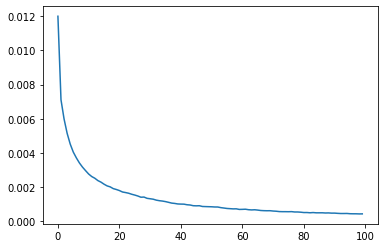

In [40]:
model_light5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_light.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_light5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_light5.load_weights("../models/LSTM_light.h5")
    logging.info("loading LSTM model from ../models/LSTM_light.h5")
except OSError as e:
    history: History = model_light5.fit(
        ds_light,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_light5.save_weights("../models/LSTM_light.h5")
    logging.info("saving LSTM model to ../models/LSTM_light.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

In [41]:
light_pred5 = model_light5.predict(np.expand_dims(x_test_light.values, 0))[0, :, 0]

<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

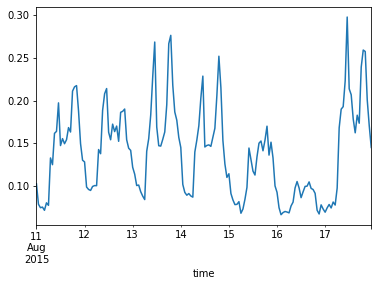

In [42]:
light_pred = (light_pred1 + light_pred2 + light_pred3 + light_pred4 + light_pred5) / 5
data_light.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_light"] = light_pred
data_light.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_light"].plot()

<h4>针对air构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

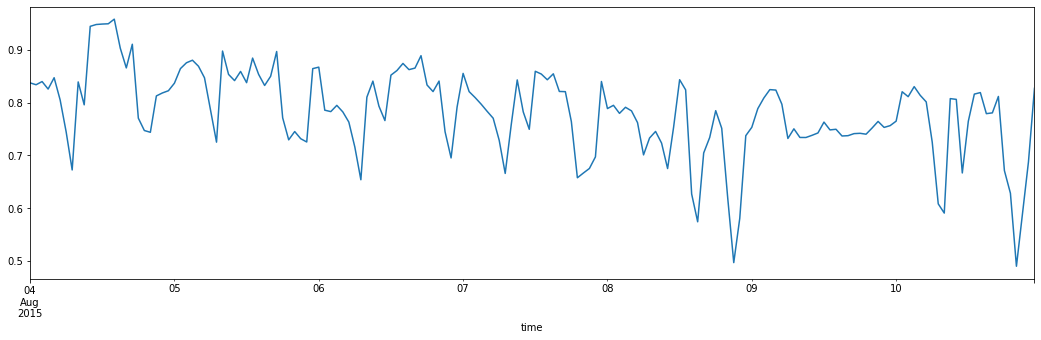

In [43]:
data.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00", "value_air"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [44]:
data_air = data.drop(columns=["value_socket", "value_light", "value_total"])
x_train_air = data_air.drop(columns=["value_air"]).loc[: "2015-08-10 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_air = data_air["value_air"].loc[: "2015-08-10 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
x_test_air = data_air.drop(columns=["value_air"]).loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00"]

sample_weight = np.arange(0, x_train_air.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [45]:
model_air1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_air, y_train_air, sample_weight=sample_weight)
air_pred1 = model_air1.predict(x_test_air)

<h5>取最后7*24个点作为模型2预测值</h5>

In [46]:
air_pred2 = data_air.loc[: "2015-08-10 23:00:00", "value_air"].values[-7*24:]

<h5>构建catboost</h5>

In [47]:
model_air3 = CatBoostRegressor(n_estimators=1000, random_state=1024).fit(x_train_air, y_train_air, sample_weight=sample_weight)
air_pred3 = model_air3.predict(x_test_air)

Learning rate set to 0.063357
0:	learn: 0.1535397	total: 3.61ms	remaining: 3.61s
1:	learn: 0.1503417	total: 6.81ms	remaining: 3.4s
2:	learn: 0.1474748	total: 9.97ms	remaining: 3.31s
3:	learn: 0.1447669	total: 13ms	remaining: 3.23s
4:	learn: 0.1423894	total: 16ms	remaining: 3.18s
5:	learn: 0.1401439	total: 19ms	remaining: 3.15s
6:	learn: 0.1382237	total: 22.3ms	remaining: 3.16s
7:	learn: 0.1361197	total: 25.2ms	remaining: 3.12s
8:	learn: 0.1344690	total: 28.1ms	remaining: 3.09s
9:	learn: 0.1327301	total: 30.9ms	remaining: 3.06s
10:	learn: 0.1312659	total: 33.8ms	remaining: 3.04s
11:	learn: 0.1299321	total: 36.9ms	remaining: 3.04s
12:	learn: 0.1285828	total: 39.8ms	remaining: 3.02s
13:	learn: 0.1273283	total: 42.6ms	remaining: 3s
14:	learn: 0.1263494	total: 45.5ms	remaining: 2.99s
15:	learn: 0.1253587	total: 48.2ms	remaining: 2.96s
16:	learn: 0.1244588	total: 50.8ms	remaining: 2.94s
17:	learn: 0.1234804	total: 53.6ms	remaining: 2.92s
18:	learn: 0.1224967	total: 56.1ms	remaining: 2.9s
19:

210:	learn: 0.0872849	total: 529ms	remaining: 1.98s
211:	learn: 0.0872298	total: 531ms	remaining: 1.97s
212:	learn: 0.0871493	total: 534ms	remaining: 1.97s
213:	learn: 0.0870499	total: 536ms	remaining: 1.97s
214:	learn: 0.0869910	total: 538ms	remaining: 1.97s
215:	learn: 0.0868552	total: 541ms	remaining: 1.96s
216:	learn: 0.0867696	total: 543ms	remaining: 1.96s
217:	learn: 0.0867238	total: 546ms	remaining: 1.96s
218:	learn: 0.0866227	total: 548ms	remaining: 1.95s
219:	learn: 0.0865728	total: 550ms	remaining: 1.95s
220:	learn: 0.0865140	total: 553ms	remaining: 1.95s
221:	learn: 0.0864678	total: 555ms	remaining: 1.95s
222:	learn: 0.0863962	total: 557ms	remaining: 1.94s
223:	learn: 0.0863505	total: 560ms	remaining: 1.94s
224:	learn: 0.0862762	total: 562ms	remaining: 1.94s
225:	learn: 0.0861965	total: 564ms	remaining: 1.93s
226:	learn: 0.0861293	total: 567ms	remaining: 1.93s
227:	learn: 0.0860548	total: 569ms	remaining: 1.93s
228:	learn: 0.0859825	total: 572ms	remaining: 1.92s
229:	learn: 

432:	learn: 0.0746330	total: 1.07s	remaining: 1.4s
433:	learn: 0.0745760	total: 1.07s	remaining: 1.4s
434:	learn: 0.0745392	total: 1.07s	remaining: 1.39s
435:	learn: 0.0744847	total: 1.07s	remaining: 1.39s
436:	learn: 0.0744284	total: 1.08s	remaining: 1.39s
437:	learn: 0.0743695	total: 1.08s	remaining: 1.39s
438:	learn: 0.0743270	total: 1.08s	remaining: 1.39s
439:	learn: 0.0742816	total: 1.09s	remaining: 1.38s
440:	learn: 0.0742432	total: 1.09s	remaining: 1.39s
441:	learn: 0.0742075	total: 1.1s	remaining: 1.38s
442:	learn: 0.0741637	total: 1.1s	remaining: 1.38s
443:	learn: 0.0741266	total: 1.1s	remaining: 1.38s
444:	learn: 0.0740928	total: 1.1s	remaining: 1.38s
445:	learn: 0.0740684	total: 1.1s	remaining: 1.37s
446:	learn: 0.0740343	total: 1.11s	remaining: 1.37s
447:	learn: 0.0739953	total: 1.12s	remaining: 1.38s
448:	learn: 0.0739299	total: 1.12s	remaining: 1.37s
449:	learn: 0.0738853	total: 1.12s	remaining: 1.37s
450:	learn: 0.0738576	total: 1.12s	remaining: 1.37s
451:	learn: 0.07382

653:	learn: 0.0670592	total: 1.61s	remaining: 850ms
654:	learn: 0.0670214	total: 1.61s	remaining: 847ms
655:	learn: 0.0669898	total: 1.61s	remaining: 845ms
656:	learn: 0.0669602	total: 1.61s	remaining: 843ms
657:	learn: 0.0669373	total: 1.62s	remaining: 840ms
658:	learn: 0.0669084	total: 1.62s	remaining: 838ms
659:	learn: 0.0668726	total: 1.62s	remaining: 835ms
660:	learn: 0.0668348	total: 1.62s	remaining: 833ms
661:	learn: 0.0668220	total: 1.63s	remaining: 831ms
662:	learn: 0.0667852	total: 1.63s	remaining: 828ms
663:	learn: 0.0667699	total: 1.63s	remaining: 826ms
664:	learn: 0.0667541	total: 1.63s	remaining: 823ms
665:	learn: 0.0667094	total: 1.64s	remaining: 821ms
666:	learn: 0.0666922	total: 1.64s	remaining: 818ms
667:	learn: 0.0666655	total: 1.64s	remaining: 816ms
668:	learn: 0.0666420	total: 1.64s	remaining: 813ms
669:	learn: 0.0666214	total: 1.65s	remaining: 811ms
670:	learn: 0.0665993	total: 1.65s	remaining: 808ms
671:	learn: 0.0665808	total: 1.65s	remaining: 806ms
672:	learn: 

872:	learn: 0.0618829	total: 2.14s	remaining: 312ms
873:	learn: 0.0618666	total: 2.15s	remaining: 310ms
874:	learn: 0.0618481	total: 2.15s	remaining: 307ms
875:	learn: 0.0618391	total: 2.15s	remaining: 305ms
876:	learn: 0.0618189	total: 2.16s	remaining: 303ms
877:	learn: 0.0617822	total: 2.16s	remaining: 300ms
878:	learn: 0.0617683	total: 2.16s	remaining: 298ms
879:	learn: 0.0617571	total: 2.16s	remaining: 295ms
880:	learn: 0.0617240	total: 2.17s	remaining: 293ms
881:	learn: 0.0617077	total: 2.17s	remaining: 290ms
882:	learn: 0.0616976	total: 2.17s	remaining: 288ms
883:	learn: 0.0616804	total: 2.17s	remaining: 285ms
884:	learn: 0.0616578	total: 2.17s	remaining: 283ms
885:	learn: 0.0616407	total: 2.18s	remaining: 280ms
886:	learn: 0.0616036	total: 2.18s	remaining: 278ms
887:	learn: 0.0615804	total: 2.18s	remaining: 275ms
888:	learn: 0.0615582	total: 2.19s	remaining: 273ms
889:	learn: 0.0615438	total: 2.19s	remaining: 270ms
890:	learn: 0.0615258	total: 2.19s	remaining: 268ms
891:	learn: 

<h5>构建xgboost</h5>

In [48]:
model_air4 = XGBRegressor(n_estimators=1000, objective='reg:gamma', n_jobs=-1, random_state=1024).fit(x_train_air.loc[y_train_air > 0], y_train_air[y_train_air > 0])
air_pred4 = model_air4.predict(x_test_air)

<h5>构建深度模型</h5>

In [49]:
ds_air1 = timeseries_dataset_from_array(
    data=data_air.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_air2 = timeseries_dataset_from_array(
    data=data_air.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_air3 = timeseries_dataset_from_array(
    data=data_air.loc["2014-12-10 17:00:00" : "2015-08-10 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_air = ds_air1.concatenate(ds_air2).concatenate(ds_air3).map(split_xy)
ds_air

<MapDataset shapes: ((None, None, 29), (None, None)), types: (tf.float64, tf.float64)>

Epoch 1/100
124/124 [==============================] - 8s 46ms/step - loss: 0.0796 - mae: 0.2071
Epoch 2/100
124/124 [==============================] - 5s 43ms/step - loss: 0.0181 - mae: 0.1044
Epoch 3/100
124/124 [==============================] - 5s 41ms/step - loss: 0.0149 - mae: 0.0946
Epoch 4/100
124/124 [==============================] - 5s 40ms/step - loss: 0.0130 - mae: 0.0881
Epoch 5/100
124/124 [==============================] - 5s 40ms/step - loss: 0.0111 - mae: 0.0809
Epoch 6/100
124/124 [==============================] - 5s 41ms/step - loss: 0.0097 - mae: 0.0753
Epoch 7/100
124/124 [==============================] - 5s 41ms/step - loss: 0.0088 - mae: 0.0718
Epoch 8/100
124/124 [==============================] - 5s 40ms/step - loss: 0.0081 - mae: 0.0685
Epoch 9/100
124/124 [==============================] - 5s 41ms/step - loss: 0.0074 - mae: 0.0653
Epoch 10/100
124/124 [==============================] - 5s 40ms/step - loss: 0.0068 - mae: 0.0625
Epoch 11/100
124/124 [=======

124/124 [==============================] - 5s 40ms/step - loss: 0.0011 - mae: 0.0223
Epoch 85/100
124/124 [==============================] - 5s 41ms/step - loss: 0.0010 - mae: 0.0217
Epoch 86/100
124/124 [==============================] - 5s 42ms/step - loss: 9.9348e-04 - mae: 0.0213
Epoch 87/100
124/124 [==============================] - 5s 42ms/step - loss: 9.7057e-04 - mae: 0.0210
Epoch 88/100
124/124 [==============================] - 5s 42ms/step - loss: 9.5631e-04 - mae: 0.0207
Epoch 89/100
124/124 [==============================] - 5s 42ms/step - loss: 9.9689e-04 - mae: 0.0214
Epoch 90/100
124/124 [==============================] - 5s 42ms/step - loss: 9.5687e-04 - mae: 0.0208
Epoch 91/100
124/124 [==============================] - 5s 41ms/step - loss: 9.4919e-04 - mae: 0.0206
Epoch 92/100
124/124 [==============================] - 5s 41ms/step - loss: 9.6402e-04 - mae: 0.0209
Epoch 93/100
124/124 [==============================] - 5s 40ms/step - loss: 9.2586e-04 - mae: 0.0203
E

2023-04-12 09:09:52,669 [INFO] saving LSTM model to ../models/LSTM_air.h5


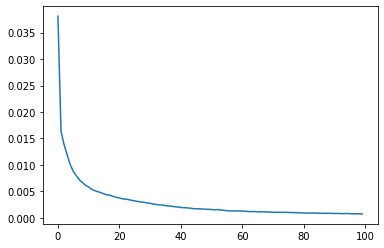

In [50]:
model_air5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_air.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_air5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_air5.load_weights("../models/LSTM_air.h5")
    logging.info("loading LSTM model from ../models/LSTM_air.h5")
except OSError as e:
    history: History = model_air5.fit(
        ds_air,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_light5.save_weights("../models/LSTM_air.h5")
    logging.info("saving LSTM model to ../models/LSTM_air.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

In [51]:
air_pred5 = model_air5.predict(np.expand_dims(x_test_air.values, 0))[0, :, 0]

<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

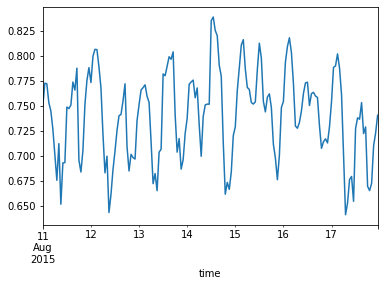

In [52]:
air_pred = (air_pred1 + air_pred2 + air_pred3 + air_pred4 + air_pred5) / 5
data_air.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_air"] = air_pred
data_air.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_air"].plot()

<h4>针对total构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

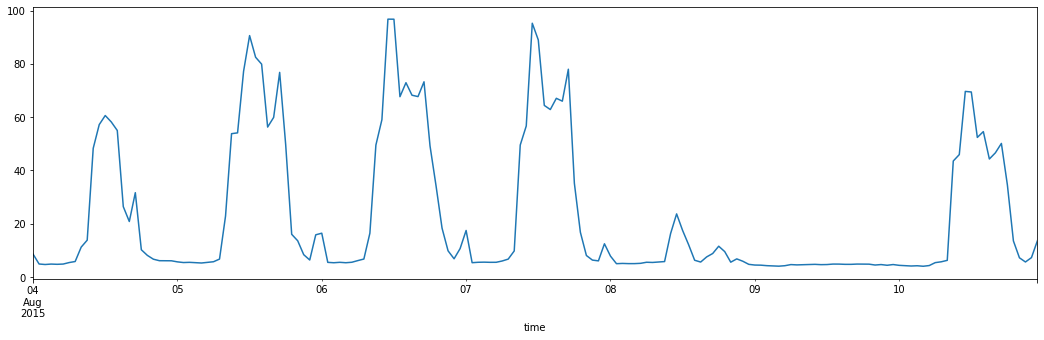

In [53]:
data.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00", "value_total"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [54]:
data_total = data.drop(columns=["value_socket", "value_light", "value_air"])
x_train_total = data_total.drop(columns=["value_total"]).loc[: "2015-08-10 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_total = data_total["value_total"].loc[: "2015-08-10 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_total = y_train_total[y_train_total > 0]
x_train_total = x_train_total.loc[y_train_total.index]
x_test_total = data_total.drop(columns=["value_total"]).loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00"]

sample_weight = np.arange(0, x_train_total.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [55]:
model_total1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_total, y_train_total, sample_weight=sample_weight)
total_pred1 = model_total1.predict(x_test_total)

<h5>取最后7*24个点作为模型2预测值</h5>

In [56]:
total_pred2 = data_total.loc[: "2015-08-10 23:00:00", "value_total"].values[-7*24:]

<h5>构建catboost</h5>

In [57]:
model_total3 = CatBoostRegressor(n_estimators=1000, random_state=1024).fit(x_train_total, y_train_total, sample_weight=sample_weight)
total_pred3 = model_total3.predict(x_test_total)

Learning rate set to 0.063357
0:	learn: 17.9276375	total: 3.46ms	remaining: 3.46s
1:	learn: 17.1601980	total: 6.63ms	remaining: 3.31s
2:	learn: 16.4567232	total: 9.65ms	remaining: 3.21s
3:	learn: 15.8084956	total: 12.8ms	remaining: 3.2s
4:	learn: 15.2151291	total: 15.9ms	remaining: 3.16s
5:	learn: 14.6656380	total: 19ms	remaining: 3.15s
6:	learn: 14.1577508	total: 22ms	remaining: 3.12s
7:	learn: 13.6980842	total: 25ms	remaining: 3.1s
8:	learn: 13.2673776	total: 28.2ms	remaining: 3.1s
9:	learn: 12.8845800	total: 31.1ms	remaining: 3.08s
10:	learn: 12.5227027	total: 33.8ms	remaining: 3.04s
11:	learn: 12.2018150	total: 36.8ms	remaining: 3.03s
12:	learn: 11.8992926	total: 39.8ms	remaining: 3.02s
13:	learn: 11.6292223	total: 42.8ms	remaining: 3.01s
14:	learn: 11.3720728	total: 45.7ms	remaining: 3s
15:	learn: 11.1417363	total: 48.7ms	remaining: 3s
16:	learn: 10.9274489	total: 51.5ms	remaining: 2.98s
17:	learn: 10.7265798	total: 55.1ms	remaining: 3s
18:	learn: 10.5606852	total: 57.9ms	remainin

214:	learn: 5.9310343	total: 525ms	remaining: 1.92s
215:	learn: 5.9270677	total: 528ms	remaining: 1.92s
216:	learn: 5.9220757	total: 530ms	remaining: 1.91s
217:	learn: 5.9139432	total: 533ms	remaining: 1.91s
218:	learn: 5.9091452	total: 535ms	remaining: 1.91s
219:	learn: 5.9041645	total: 537ms	remaining: 1.9s
220:	learn: 5.8988425	total: 539ms	remaining: 1.9s
221:	learn: 5.8925553	total: 542ms	remaining: 1.9s
222:	learn: 5.8877148	total: 544ms	remaining: 1.9s
223:	learn: 5.8745521	total: 547ms	remaining: 1.89s
224:	learn: 5.8618515	total: 549ms	remaining: 1.89s
225:	learn: 5.8567669	total: 551ms	remaining: 1.89s
226:	learn: 5.8453912	total: 553ms	remaining: 1.88s
227:	learn: 5.8407270	total: 556ms	remaining: 1.88s
228:	learn: 5.8310206	total: 558ms	remaining: 1.88s
229:	learn: 5.8264362	total: 560ms	remaining: 1.87s
230:	learn: 5.8192363	total: 562ms	remaining: 1.87s
231:	learn: 5.8126035	total: 565ms	remaining: 1.87s
232:	learn: 5.8072337	total: 567ms	remaining: 1.87s
233:	learn: 5.80

442:	learn: 4.8604789	total: 1.06s	remaining: 1.34s
443:	learn: 4.8573294	total: 1.07s	remaining: 1.34s
444:	learn: 4.8529906	total: 1.07s	remaining: 1.34s
445:	learn: 4.8498346	total: 1.08s	remaining: 1.34s
446:	learn: 4.8472907	total: 1.08s	remaining: 1.33s
447:	learn: 4.8440060	total: 1.08s	remaining: 1.33s
448:	learn: 4.8413878	total: 1.08s	remaining: 1.33s
449:	learn: 4.8381418	total: 1.08s	remaining: 1.33s
450:	learn: 4.8348511	total: 1.09s	remaining: 1.32s
451:	learn: 4.8325171	total: 1.09s	remaining: 1.32s
452:	learn: 4.8295447	total: 1.09s	remaining: 1.32s
453:	learn: 4.8261480	total: 1.09s	remaining: 1.31s
454:	learn: 4.8235675	total: 1.1s	remaining: 1.31s
455:	learn: 4.8213854	total: 1.1s	remaining: 1.31s
456:	learn: 4.8184808	total: 1.1s	remaining: 1.31s
457:	learn: 4.8161446	total: 1.1s	remaining: 1.3s
458:	learn: 4.8146881	total: 1.1s	remaining: 1.3s
459:	learn: 4.8126438	total: 1.11s	remaining: 1.3s
460:	learn: 4.8091558	total: 1.11s	remaining: 1.3s
461:	learn: 4.8050600

672:	learn: 4.2820899	total: 1.6s	remaining: 780ms
673:	learn: 4.2805143	total: 1.61s	remaining: 778ms
674:	learn: 4.2787559	total: 1.61s	remaining: 775ms
675:	learn: 4.2765384	total: 1.61s	remaining: 773ms
676:	learn: 4.2742109	total: 1.61s	remaining: 770ms
677:	learn: 4.2710370	total: 1.62s	remaining: 768ms
678:	learn: 4.2700483	total: 1.62s	remaining: 766ms
679:	learn: 4.2690811	total: 1.62s	remaining: 763ms
680:	learn: 4.2663217	total: 1.62s	remaining: 761ms
681:	learn: 4.2632282	total: 1.63s	remaining: 758ms
682:	learn: 4.2614734	total: 1.63s	remaining: 756ms
683:	learn: 4.2594107	total: 1.63s	remaining: 754ms
684:	learn: 4.2570428	total: 1.63s	remaining: 751ms
685:	learn: 4.2550108	total: 1.64s	remaining: 749ms
686:	learn: 4.2521231	total: 1.64s	remaining: 746ms
687:	learn: 4.2504677	total: 1.64s	remaining: 744ms
688:	learn: 4.2475876	total: 1.64s	remaining: 741ms
689:	learn: 4.2452720	total: 1.64s	remaining: 739ms
690:	learn: 4.2436890	total: 1.65s	remaining: 737ms
691:	learn: 4

902:	learn: 3.8970292	total: 2.15s	remaining: 231ms
903:	learn: 3.8963486	total: 2.15s	remaining: 228ms
904:	learn: 3.8948003	total: 2.15s	remaining: 226ms
905:	learn: 3.8937251	total: 2.15s	remaining: 223ms
906:	learn: 3.8929731	total: 2.15s	remaining: 221ms
907:	learn: 3.8910280	total: 2.16s	remaining: 219ms
908:	learn: 3.8901970	total: 2.16s	remaining: 216ms
909:	learn: 3.8886584	total: 2.16s	remaining: 214ms
910:	learn: 3.8871911	total: 2.16s	remaining: 211ms
911:	learn: 3.8860695	total: 2.17s	remaining: 209ms
912:	learn: 3.8842678	total: 2.17s	remaining: 207ms
913:	learn: 3.8837137	total: 2.17s	remaining: 204ms
914:	learn: 3.8815622	total: 2.17s	remaining: 202ms
915:	learn: 3.8795180	total: 2.18s	remaining: 200ms
916:	learn: 3.8770481	total: 2.18s	remaining: 197ms
917:	learn: 3.8761339	total: 2.18s	remaining: 195ms
918:	learn: 3.8758097	total: 2.18s	remaining: 192ms
919:	learn: 3.8739055	total: 2.19s	remaining: 190ms
920:	learn: 3.8729681	total: 2.19s	remaining: 188ms
921:	learn: 

<h5>构建xgboost</h5>

In [58]:
model_total4 = XGBRegressor(n_estimators=1000, objective='reg:gamma', n_jobs=-1, random_state=1024).fit(x_train_total, y_train_total)
total_pred4 = model_total4.predict(x_test_total)
# TODO 改为objective='reg:linear'，并加入sample_weight

<h5>构建深度模型</h5>

In [59]:
ds_total1 = timeseries_dataset_from_array(
    data=data_total.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_total2 = timeseries_dataset_from_array(
    data=data_total.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_total3 = timeseries_dataset_from_array(
    data=data_total.loc["2014-12-10 17:00:00" : "2015-08-10 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_total = ds_total1.concatenate(ds_total2).concatenate(ds_total3).map(split_xy)
ds_total

<MapDataset shapes: ((None, None, 29), (None, None)), types: (tf.float64, tf.float64)>

Epoch 1/150
124/124 [==============================] - 8s 45ms/step - loss: 746.3049 - mae: 18.4340
Epoch 2/150
124/124 [==============================] - 5s 40ms/step - loss: 356.0789 - mae: 12.0662
Epoch 3/150
124/124 [==============================] - 5s 40ms/step - loss: 148.1069 - mae: 7.8073
Epoch 4/150
124/124 [==============================] - 5s 40ms/step - loss: 105.5719 - mae: 6.6554
Epoch 5/150
124/124 [==============================] - 5s 40ms/step - loss: 84.6693 - mae: 6.0235
Epoch 6/150
124/124 [==============================] - 5s 40ms/step - loss: 68.0420 - mae: 5.4218
Epoch 7/150
124/124 [==============================] - 5s 41ms/step - loss: 59.5121 - mae: 5.0867
Epoch 8/150
124/124 [==============================] - 5s 41ms/step - loss: 52.3982 - mae: 4.7660
Epoch 9/150
124/124 [==============================] - 5s 40ms/step - loss: 46.7282 - mae: 4.5170
Epoch 10/150
124/124 [==============================] - 5s 40ms/step - loss: 43.0172 - mae: 4.3338
Epoch 11/150


124/124 [==============================] - 5s 40ms/step - loss: 5.9239 - mae: 1.4640
Epoch 85/150
124/124 [==============================] - 5s 40ms/step - loss: 5.2181 - mae: 1.3904
Epoch 86/150
124/124 [==============================] - 5s 40ms/step - loss: 5.0057 - mae: 1.3665
Epoch 87/150
124/124 [==============================] - 5s 40ms/step - loss: 5.2181 - mae: 1.3966
Epoch 88/150
124/124 [==============================] - 5s 40ms/step - loss: 5.0650 - mae: 1.3599
Epoch 89/150
124/124 [==============================] - 5s 41ms/step - loss: 4.8895 - mae: 1.3398
Epoch 90/150
124/124 [==============================] - 5s 40ms/step - loss: 4.9519 - mae: 1.3356
Epoch 91/150
124/124 [==============================] - 5s 41ms/step - loss: 4.8351 - mae: 1.3269
Epoch 92/150
124/124 [==============================] - 5s 40ms/step - loss: 4.4361 - mae: 1.2731
Epoch 93/150
124/124 [==============================] - 5s 41ms/step - loss: 4.7736 - mae: 1.3223
Epoch 94/150
124/124 [===========

2023-04-12 09:22:48,381 [INFO] saving LSTM model to ../models/LSTM_total.h5


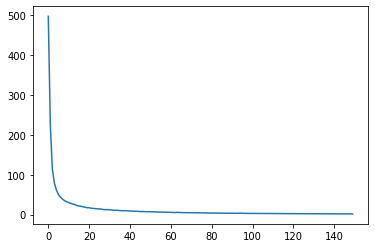

In [60]:
model_total5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_total.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_total5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_total5.load_weights("../models/LSTM_total.h5")
    logging.info("loading LSTM model from ../models/LSTM_total.h5")
except OSError as e:
    history: History = model_total5.fit(
        ds_total,
        batch_size=128,
        epochs=150,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_total5.save_weights("../models/LSTM_total.h5")
    logging.info("saving LSTM model to ../models/LSTM_total.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

In [61]:
total_pred5 = model_total5.predict(np.expand_dims(x_test_total.values, 0))[0, :, 0]

<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

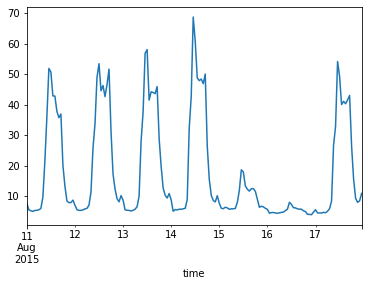

In [62]:
total_pred = (total_pred1 + total_pred2 + total_pred3 + total_pred4 + total_pred5) / 5
data_total.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_total"] = total_pred
data_total.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_total"].plot()

<h3>预测未来七天的各项能耗，并输出用于评测的.csv文件：</h3>

In [63]:
results = DataFrame(index=pd.date_range(start="2015-08-11 00:00:00", end="2015-08-17 23:00:00", freq="1H"))
results['socket'] = clip_value(socket_pred * total_pred, _min_val_=0)
results['light'] = clip_value(light_pred * total_pred, _min_val_=0)
results['air'] = clip_value(air_pred * total_pred, _min_val_=0)
results['total'] = clip_value(total_pred, _min_val_=0)
results = results[["total", "socket", "light", "air"]]
filename = "submit_%s.csv" % datetime.now().strftime("%Y-%m-%dT%H-%M")

results.to_csv(os.path.join("../data", filename), index=False)
results

,total,socket,light,air
2015-08-11 00:00:00,7.615446,0.965943,0.780674,5.717896
2015-08-11 01:00:00,5.447264,0.708854,0.428584,4.211837
2015-08-11 02:00:00,5.145443,0.702277,0.383946,3.975212
2015-08-11 03:00:00,4.956304,0.691125,0.373284,3.735565
2015-08-11 04:00:00,5.257438,0.768299,0.376297,3.919424
...,...,...,...,...
2015-08-17 19:00:00,15.518639,1.501247,4.022830,10.333241
2015-08-17 20:00:00,9.269552,1.235690,2.386951,6.238877
2015-08-17 21:00:00,7.918504,1.229730,1.590365,5.626818
2015-08-17 22:00:00,8.421617,1.260677,1.436557,6.092261


In [64]:
with ZipFile('../data/test.zip', 'w') as zip_file:
    zip_file.write(os.path.join("../data", filename), filename, compress_type=zipfile.ZIP_DEFLATED)